<a href="https://colab.research.google.com/github/diegomartinmendez/CEIA_PLN_1/blob/main/Desafio_4_Diego_Mendez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facultad de Ingeniería - Universidad de Buenos Aires
## Laboratorio de Sistemas Embebidos
## Carrera de Especialización en Inteligencia Artificial
## Procesamiento Natual del Lenguaje I
### 2° Bimestre 2025 - Cohorte 17
### Mg. Ing. Diego Martín Méndez

## Desafío 4
## LSTM Bot QA

### Datos

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import os
from pathlib import Path
import pickle

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences, to_categorical, plot_model
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Dense, Flatten, LSTM, Input
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [3]:
# Descargar la carpeta de dataset:
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [4]:
# Dataset_file:
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

In [5]:
# Observar los campos disponibles en cada linea del dataset:
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [6]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene
        output_sentence = output + ' '
        # output sentence input (decoder_input) tiene
        output_sentence_input = ' ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [7]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_words = 10

def clean_text(txt):
    txt = txt.lower()
    txt = txt.replace("\'d", " had")
    txt = txt.replace("\'s", " is")
    txt = txt.replace("\'m", " am")
    txt = txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

count_exceeds = 0
for line in data:
    for i in range(len(line['dialog'])-1):
        # separamos el texto en "preguntas" (chat_in) y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        # Medir por número de palabras
        if len(chat_in.split()) >= max_words or len(chat_out.split()) >= max_words:
            count_exceeds += 1
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene
        output_sentence = output + ' '
        # output sentence input (decoder_input) tiene
        output_sentence_input = ' ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

In [8]:
print("Cantidad de intercambios utilizados:", len(input_sentences))
print("Cantidad de intercambios descartados por longitud:", count_exceeds)

Cantidad de intercambios utilizados: 10752
Cantidad de intercambios descartados por longitud: 2760


In [9]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  ', ' not bad and you ')

### Preprocesamiento

In [10]:
MAX_VOCAB_SIZE = 8000

In [11]:
# input tokenizer
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario de entrada:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario de entrada: 3131
Sentencia de entrada más larga: 11


In [12]:
# output tokenizer
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=?@[\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["", ""] + output_sentences)
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario de salida:", len(word2idx_outputs))

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)

Palabras en el vocabulario de salida: 3146
Sentencia de salida más larga: 11


In [37]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)


Cantidad de rows del dataset: 10752
encoder_input_sequences shape: (10752, 11)
decoder_input_sequences shape: (10752, 11)


In [14]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
print("decoder_output_sequences shape:", decoder_output_sequences.shape)
print("decoder_targets shape:", decoder_targets.shape)

decoder_output_sequences shape: (10752, 11)
decoder_targets shape: (10752, 11, 3147)


### Preparación de los Embeddings

In [15]:
# Descarga emebeddings de FastText:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gunzip cc.en.300.vec.gz

--2025-06-23 08:39:42--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.31, 18.173.166.74, 18.173.166.48, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz.2’

cc.en.300.vec.gz.2  100%[===================>]   1.23G  23.4MB/s    in 18s     

2025-06-23 08:40:00 (68.9 MB/s) - ‘cc.en.300.vec.gz.2’ saved [1325960915/1325960915]

gzip: cc.en.300.vec already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [16]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [17]:
model_embeddings = FasttextEmbeddings()

In [18]:
# Crear la Embedding matrix de las secuencias

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [19]:
# Dimensión de los embeddings de la secuencia
embedding_matrix.shape

(3131, 300)

### Entrenamiento del modelo

In [20]:
n_units = 128

# Encoder:
encoder_inputs = Input(shape=(max_input_len,))
encoder_embedding_layer = Embedding(
    input_dim=nb_words,
    output_dim=embed_dim,
    input_length=max_input_len,
    weights=[embedding_matrix],
    trainable=False
)
encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True, dropout=0.5)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# Decoder:
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_embedded  = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_embedded , initial_state=encoder_states)

decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compilar el modelo:
model.compile(
    loss='categorical_crossentropy',
    optimizer="Adam",
    metrics=['accuracy']
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 11, 300)   │    939,300 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 11, 128)   │    402,816 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 128),     │    219,648 │ embedding[0][0]   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 11, 128), │    131,584 │ embedding_1[0][0… │
│                     │ (None, 128),      │            │ lstm[0][1],       │
│                     │ (None, 128)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 11, 3147)  │    405,963 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,099,311 (8.01 MB)

 Trainable params: 1,160,011 (4.43 MB)

 Non-trainable params: 939,300 (3.58 MB)

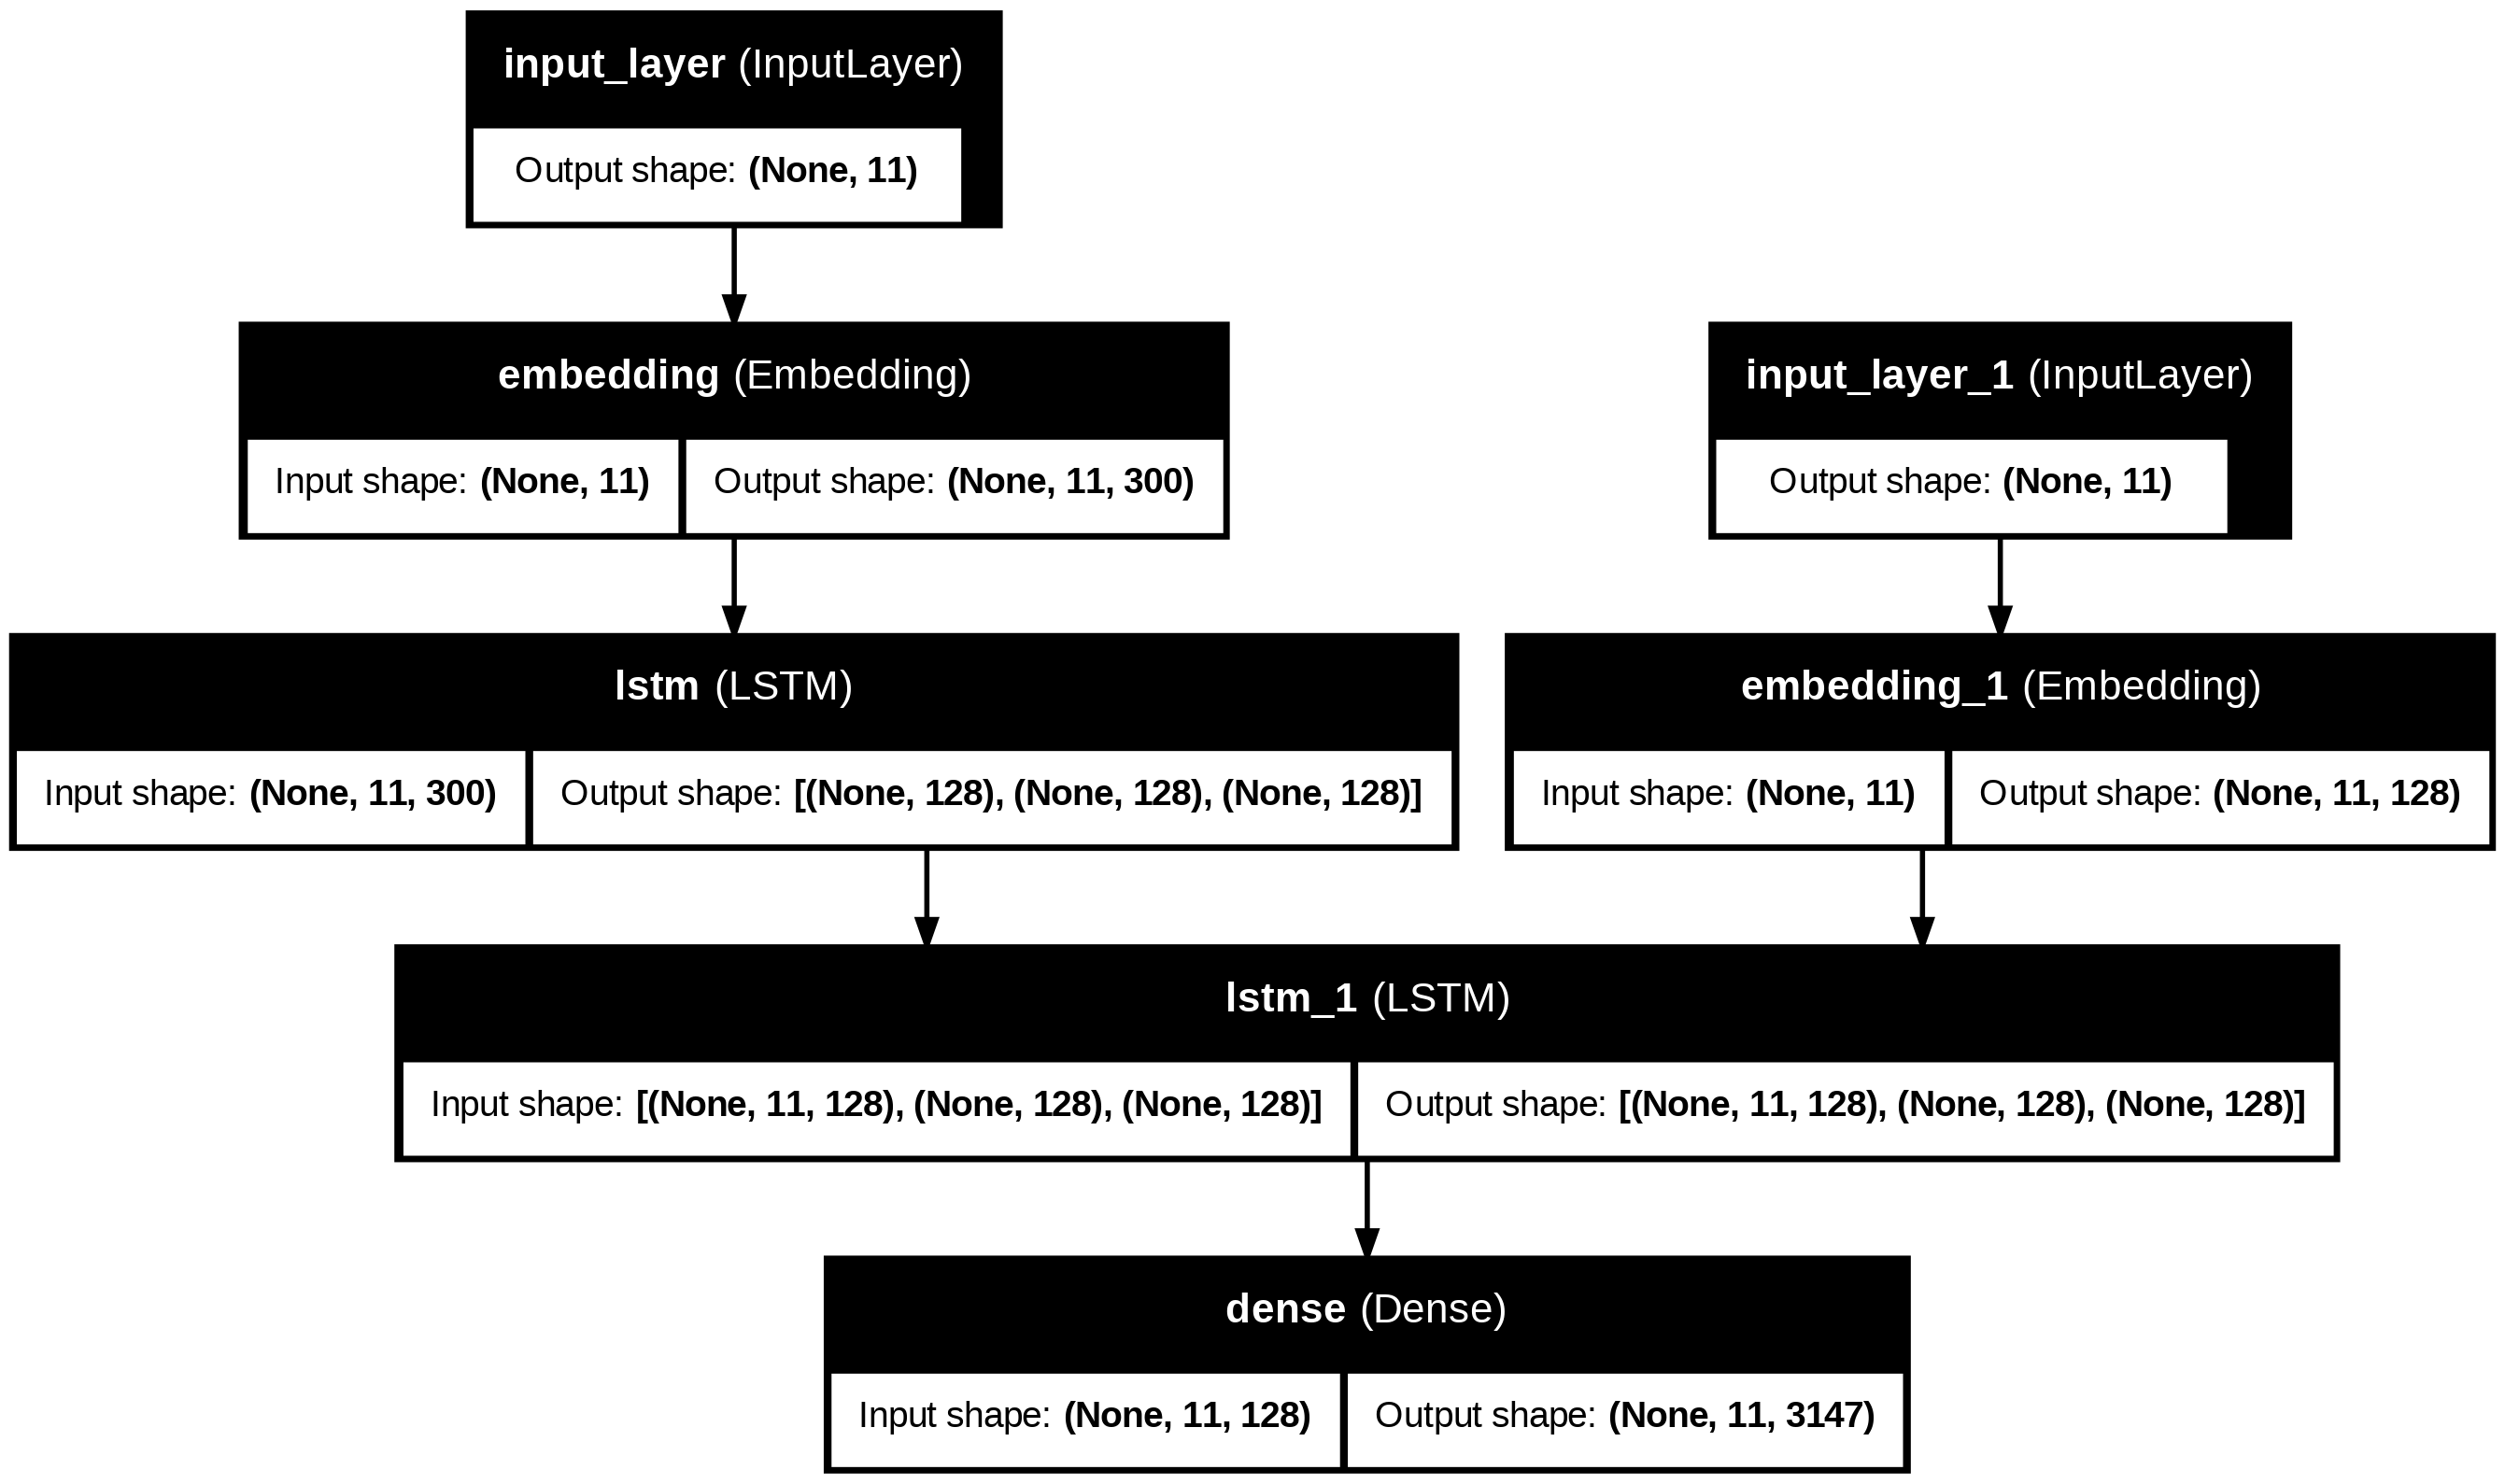

In [22]:
# Modelo completo (encoder + decoder) para entrenamiento:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

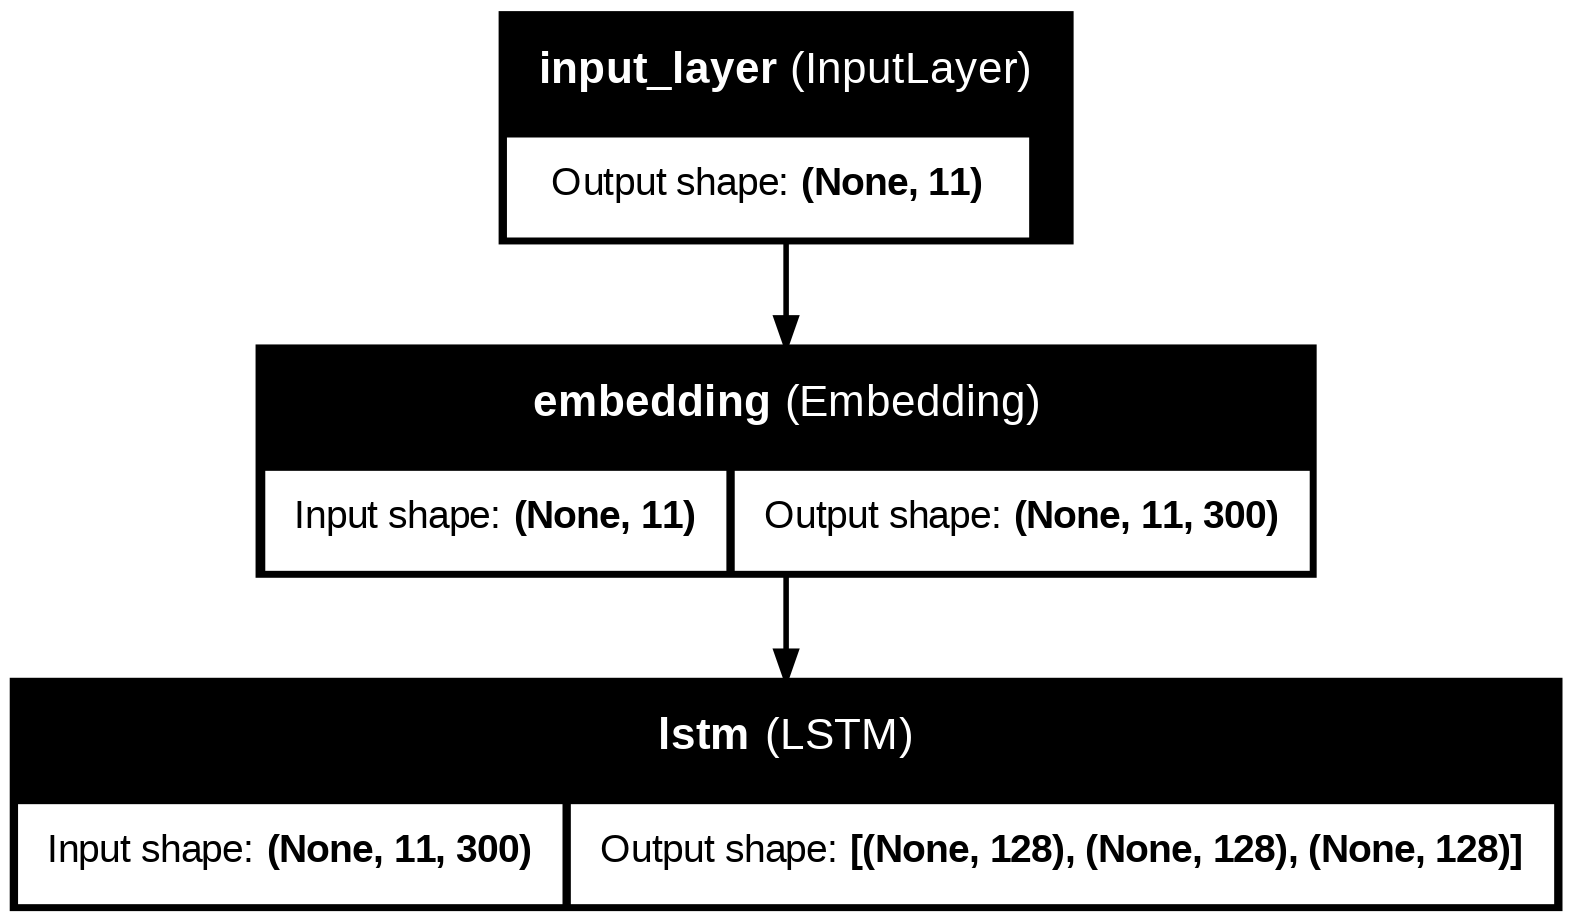

In [23]:
# Modelo solo encoder:

# define inference encoder:
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

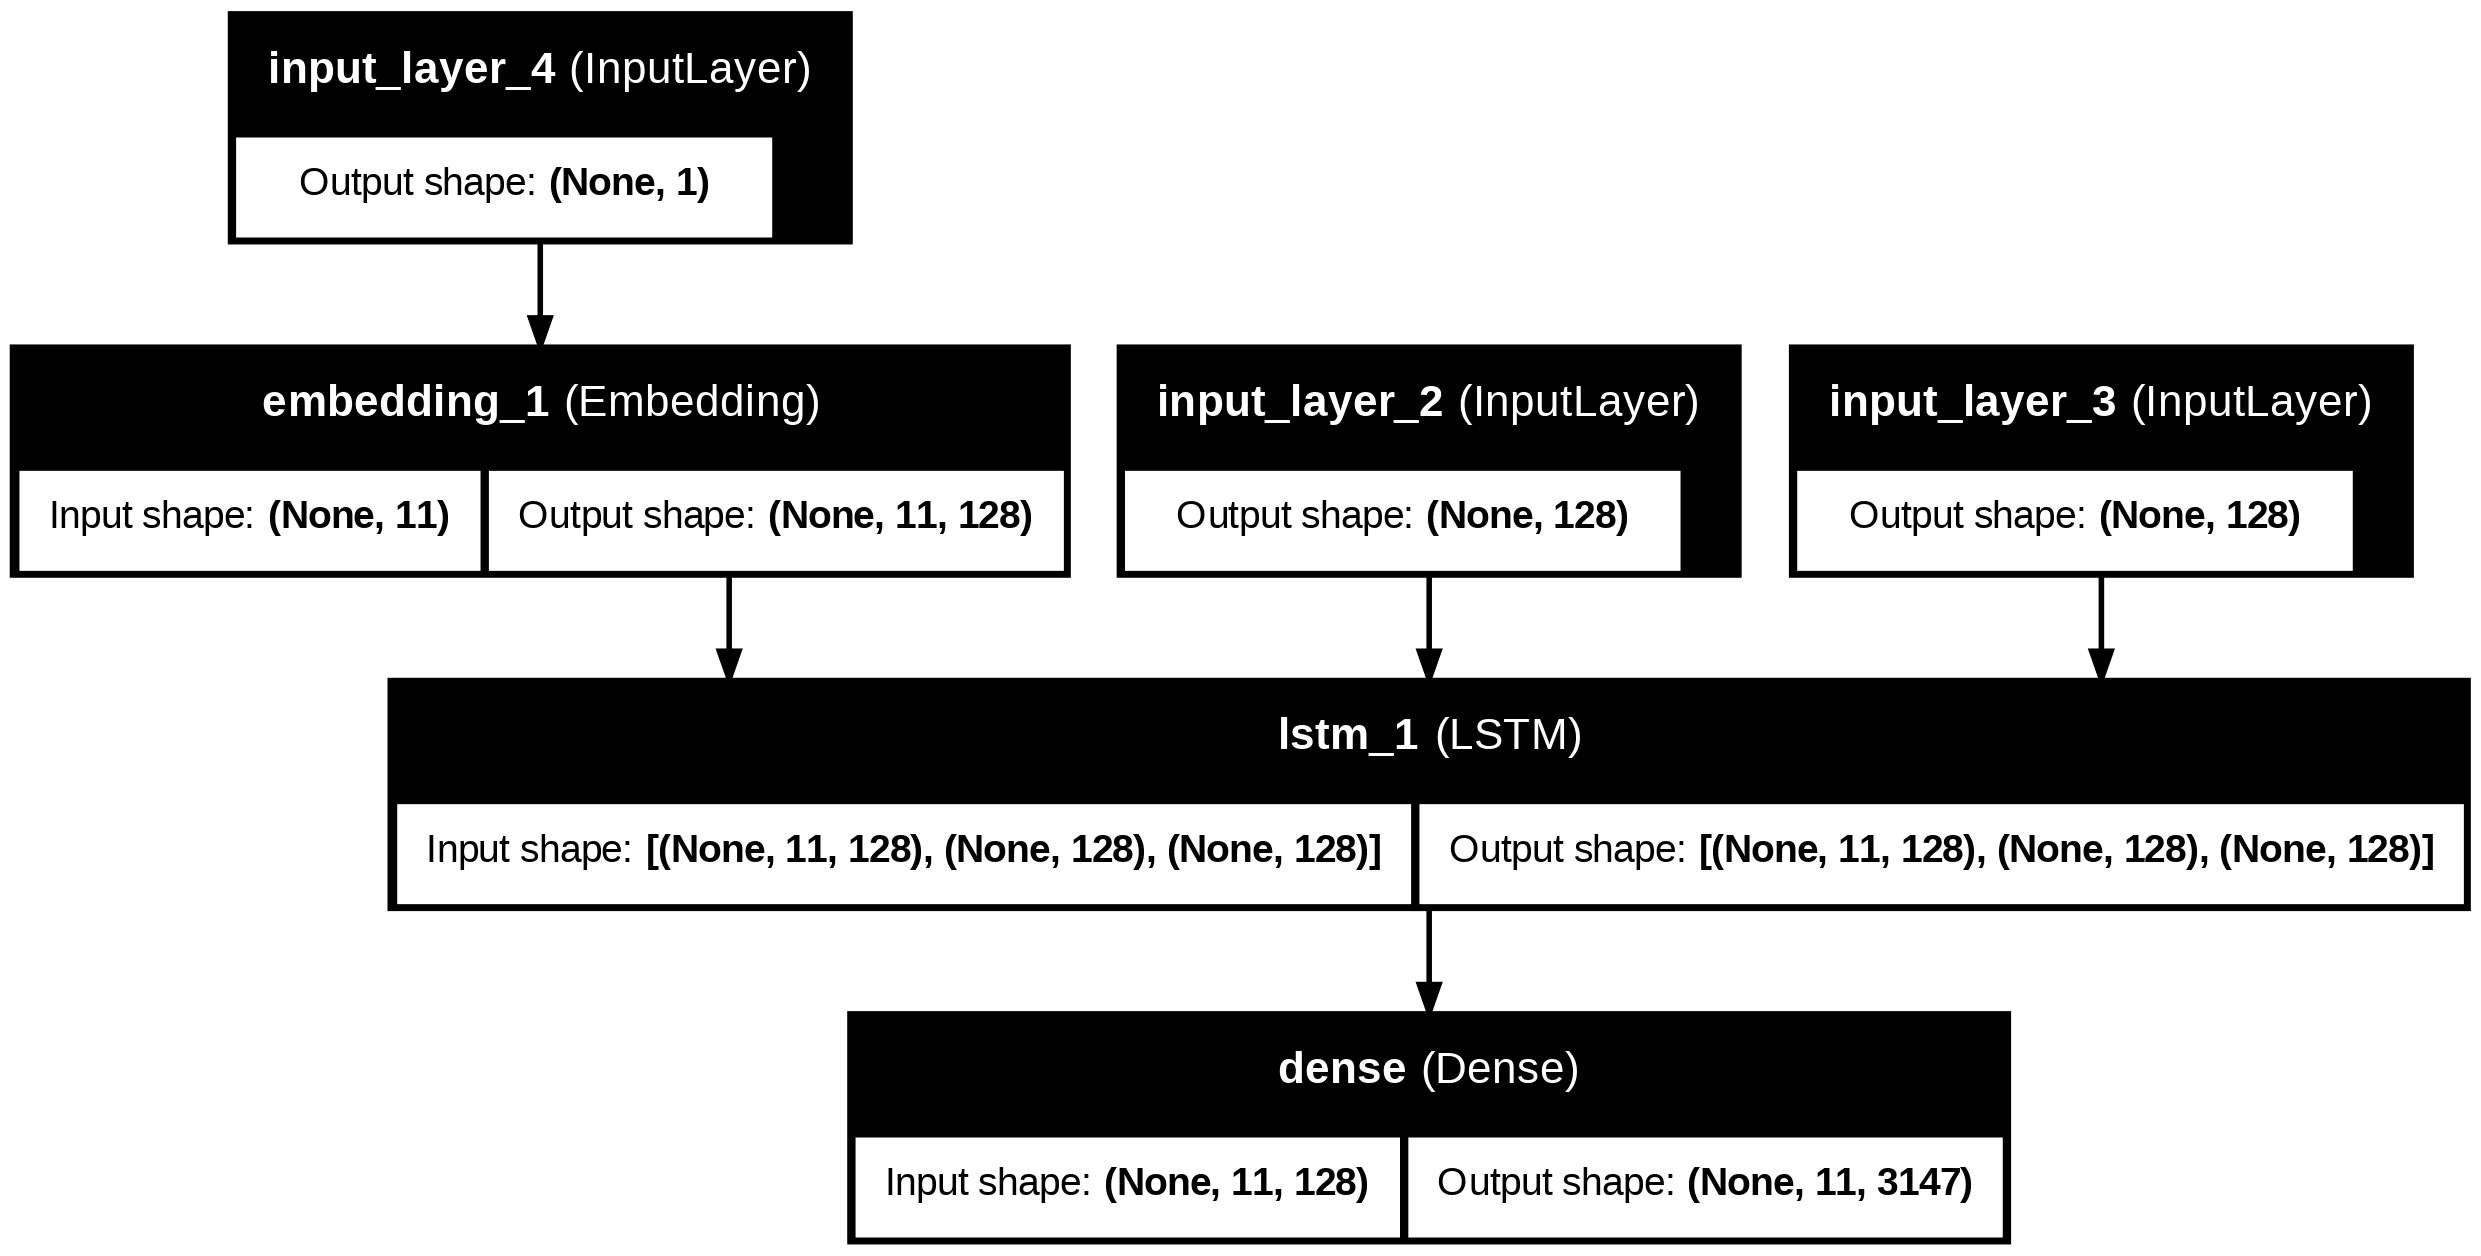

In [24]:
# Modelo solo decoder (para realizar inferencia):

# define inference decoder:
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [25]:
# Definición de callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=0
)


# Entrenamiento con callbacks
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5248 - loss: 3.9773 - val_accuracy: 0.6124 - val_loss: 2.1578 - learning_rate: 0.0010
Epoch 2/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6447 - loss: 1.9709 - val_accuracy: 0.7511 - val_loss: 1.6309 - learning_rate: 0.0010
Epoch 3/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7719 - loss: 1.4385 - val_accuracy: 0.8143 - val_loss: 1.3106 - learning_rate: 0.0010
Epoch 4/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8346 - loss: 1.1108 - val_accuracy: 0.8544 - val_loss: 1.0843 - learning_rate: 0.0010
Epoch 5/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8731 - loss: 0.8836 - val_accuracy: 0.8799 - val_loss: 0.9333 - learning_rate: 0.0010
Epoch 6/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8942 - loss: 0.7544 - val_accuracy: 0.8974 - val_loss: 0.8204 - learning_rate: 0.0010
Epoch 7/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9122 - loss: 0

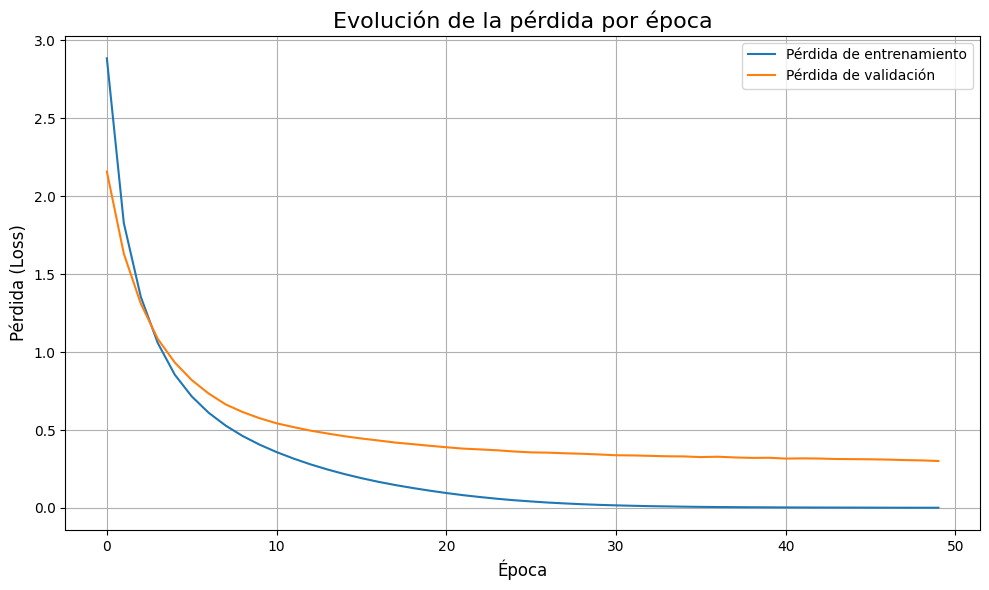

In [26]:
import matplotlib.pyplot as plt

# Gráfico de pérdida (loss)
plt.figure(figsize=(10, 6))
plt.plot(hist.history['loss'], label='Pérdida de entrenamiento')
plt.plot(hist.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida por época', fontsize=16)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Pérdida (Loss)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

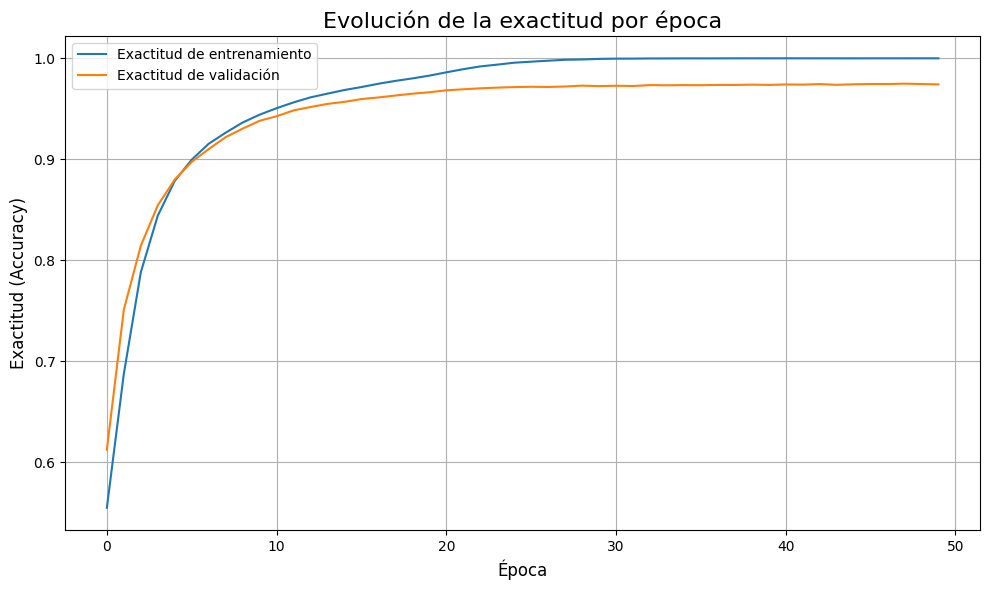

In [27]:
# Gráfico de exactitud (accuracy)
plt.figure(figsize=(10, 6))
plt.plot(hist.history['accuracy'], label='Exactitud de entrenamiento')
plt.plot(hist.history['val_accuracy'], label='Exactitud de validación')
plt.title('Evolución de la exactitud por época', fontsize=16)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Exactitud (Accuracy)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Inferencia

In [28]:
# Test:

questions = [
    "Hello",
    "What is your name?",
    "Do you speak Italian?",
    "Are you from Japan?",
    "What is your job?",
    "Do you play chess?",
    "Does the bus arrive at 6pm?",
    "Is Paris a city of France?"
]

In [41]:
idx2word_target = {v: k for k, v in word2idx_outputs.items()}

In [42]:
def generar_respuesta(secuencia_entrada):
    # Obtener los estados iniciales del encoder
    estados_iniciales = encoder_model.predict(secuencia_entrada)

    # Entrada inicial del decoder: token <sos>
    entrada_decoder = np.zeros((1, 1))
    entrada_decoder[0, 0] = word2idx_outputs['<sos>']

    # Token que marca el fin de la secuencia
    id_eos = word2idx_outputs['<eos>']

    # Lista para ir acumulando las palabras generadas
    frase_generada = []

    for _ in range(max_out_len):
        # Ejecutar una predicción con el decoder
        salida_tokens, estado_h, estado_c = decoder_model.predict([entrada_decoder] + estados_iniciales)

        # Obtener el índice de la palabra más probable
        idx_palabra = np.argmax(salida_tokens[0, 0, :])

        # Si es el token de fin, detener
        if idx_palabra == id_eos:
            break

        # Agregar la palabra correspondiente a la lista
        palabra = idx2word_target.get(idx_palabra, '')
        if palabra:
            frase_generada.append(palabra)

        # Actualizar entradas para el próximo paso
        entrada_decoder[0, 0] = idx_palabra
        estados_iniciales = [estado_h, estado_c]

    return ' '.join(frase_generada)

In [43]:
# Probar el modelo con la lista de preguntas en inglés
for pregunta in questions:
    secuencia_codificada = input_tokenizer.texts_to_sequences([pregunta])[0]
    entrada_padded = pad_sequences([secuencia_codificada], maxlen=max_input_len)

    respuesta_generada = generar_respuesta(entrada_padded)

    print(f"Pregunta:   {pregunta}")
    print(f"Respuesta: {respuesta_generada}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Pregunta:   Hello
Respuesta: helloz helloz helloz helloz helloz literature literature literature literature literature literature

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/